In [ ]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt, save_opt
import matplotlib.pyplot as plt
import torch 
import json
import seaborn as sns
import numpy as np
import pandas as pd
from infopath.utils.functions import run_with_perturbation
from infopath.train import t_trial_pearson
import os
from infopath.losses import trial_matching_loss, hard_trial_matching_loss
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
import matplotlib

%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"Arial"}
matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
os.chdir("..")

In [ ]:
logs = {
    "nofb": [
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_40_nofb_0000_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_30_nofb_0000_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_30_nofb_0000_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_30_nofb_0001_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_30_nofb_0001_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_31_nofb_0001_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_31_nofb_0003_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_31_nofb_0003_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_31_nofb_0003_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_32_nofb_0006_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_34_nofb_0006_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_35_nofb_0006_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_36_nofb_0016_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_38_nofb_0016_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_37_nofb_0016_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_37_nofb_0040_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_37_nofb_0040_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_38_nofb_0040_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_40_nofb_0100_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_40_nofb_0100_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_41_nofb_0100_2",
    ],
    "withfb1": [
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_28_42_withfb1_0000_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_44_27_withfb1_0000_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_50_55_withfb1_0000_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_50_46_withfb1_0001_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_50_55_withfb1_0001_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_50_58_withfb1_0001_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_51_35_withfb1_0003_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_51_41_withfb1_0003_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_51_35_withfb1_0003_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_51_35_withfb1_0006_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_51_16_withfb1_0006_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_18_51_17_withfb1_0006_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_7_19_withfb1_0016_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_7_19_withfb1_0016_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_7_19_withfb1_0016_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_7_19_withfb1_0040_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_7_21_withfb1_0040_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_7_22_withfb1_0040_2",

        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_7_23_withfb1_0100_0",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_7_24_withfb1_0100_1",
        "AllModels/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_11_19_9_20_withfb1_0100_2",
    ]
}

refcirc = {
    "nofb" : "AllModels/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf_block/",
    "withfb1": "AllModels/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf/",
}

In [ ]:
trials = 2000
opt = load_training_opt(refcirc["nofb"])
model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
spikes_nofb = run_with_perturbation(model, 0, 0, power=0, seed=0, trials=trials, thr=8)[-1]

trials = 2000
opt = load_training_opt(refcirc["withfb1"])
model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
spikes_withfb1 = run_with_perturbation(model, 0, 0, power=0, seed=0, trials=trials, thr=8)[-1]

filt = lambda x: model.filter_fun2(model.filter_fun1(x))  
refcirc_act = {"nofb": filt(spikes_nofb), "withfb1": filt(spikes_withfb1)}

In [5]:
df = pd.DataFrame(columns=["l1_strength", "t_trial_loss","t_trial_loss_calc", "hypothesis"])
for hypothesis in ["nofb", "withfb1"]:
    for log in logs[hypothesis]:
        results = json.load(open(f"{log}/results.json"))
        opt = load_training_opt(log)
        model = load_model_and_optimizer(opt, reload=True, last_best="step_4000")[0]
        spikes = run_with_perturbation(model, 0, 0, power=0, seed=1, trials=trials, thr=8)[-1]
        trial_loss = trial_matching_loss(
            model, 
            refcirc_act[hypothesis], 
            filt(spikes), 
            [[model.rsnn.area_index>-1]], 
            None, 
            None, 
            hard_trial_matching_loss,
            model.rsnn.area_index, 
            model.rsnn.excitatory_index
        ).item() * opt.coeff_trial_loss
        index = np.argmin(results["test_loss"])
        entry = {"l1_strength": opt.l1_decay_across, "t_trial_loss_calc": trial_loss, "t_trial_loss": results["trial_loss"][index], "hypothesis": hypothesis}
        df = pd.concat([df, pd.DataFrame(entry, index=[0])])
        print(opt.l1_decay_across, trial_loss, results["trial_loss"][index])

0.0 2.781558036804199 3.072038418650627
0.0 2.8692933917045593 3.150764736533165
0.0 2.674516439437866 3.175183753371239
0.001 2.714521586894989 3.077798118591309
0.001 2.9030388593673706 3.1660914182662965
0.001 2.7263829112052917 3.206878977417946
0.0025118864315095794 2.7383816242218018 3.0984071612358095
0.0025118864315095794 2.655440866947174 3.135330095291138
0.0025118864315095794 2.718276083469391 3.1744534343481066
0.006309573444801929 2.7743765711784363 3.2258783572912217
0.006309573444801929 2.728273570537567 3.1144065302610398
0.006309573444801929 2.8349992632865906 3.120024010539055
0.01584893192461114 2.6344677805900574 3.1343979066610337
0.01584893192461114 2.764747440814972 3.193897584080696
0.01584893192461114 2.7574005722999573 3.4792825376987455
0.039810717055349734 2.8507012128829956 3.2150531357526777
0.039810717055349734 2.7726158499717712 3.223471655845642
0.039810717055349734 2.880728542804718 3.305939271450043
0.09999999999999999 2.964811325073242 3.469823948144

In [6]:
df

,l1_strength,t_trial_loss,t_trial_loss_calc,hypothesis
0,0.000000,3.072038,2.781558,nofb
0,0.000000,3.150765,2.869293,nofb
0,0.000000,3.175184,2.674516,nofb
0,0.001000,3.077798,2.714522,nofb
0,0.001000,3.166091,2.903039,nofb
0,0.001000,3.206879,2.726383,nofb
0,0.002512,3.098407,2.738382,nofb
0,0.002512,3.135330,2.655441,nofb
0,0.002512,3.174453,2.718276,nofb
0,0.006310,3.225878,2.774377,nofb


In [10]:
df_new.groupby("l1_strength").mean("t_trial_loss_calc")

,t_trial_loss,t_trial_loss_calc
l1_strength,,
0.001000,3.110177,2.797872
0.002512,3.091970,2.733651
0.006310,3.107993,2.755656
0.015849,3.160737,2.807844
0.039811,3.210142,2.832151
0.100000,3.298329,2.923668


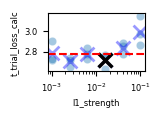

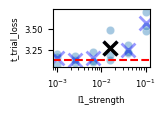

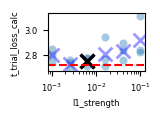

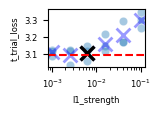

In [47]:
fig, ax = plot_with_size(25,15)
df_new = df[df.hypothesis == "nofb"]
plt.axhline(df_new[df_new.l1_strength == 0.0].t_trial_loss_calc.mean(), color="red", linestyle="--")
df_new = df_new[df_new.l1_strength != 0.0]
sns.scatterplot(data=df_new, x="l1_strength", y="t_trial_loss_calc", alpha=0.4)
df_new = df_new.groupby("l1_strength").mean("t_trial_loss_calc")
df_new.reset_index(inplace=True)    
plt.scatter(df_new.l1_strength.values, df_new.t_trial_loss_calc.values, alpha=0.4, color="blue", marker="x", s=100, linewidth=2)
plt.scatter(df_new.loc[3,"l1_strength"], df_new.loc[3, "t_trial_loss_calc"], alpha=1, color="black", marker="x", s=100, linewidth=2.5)
plt.xscale("log")
fig.savefig("FiguresOpto/Supplementary_Figure2/figureS2a.pdf", dpi=300)

fig, ax = plot_with_size(25,15)
df_new = df[df.hypothesis == "nofb"]
plt.axhline(df_new[df_new.l1_strength == 0.0].t_trial_loss.mean(), color="red", linestyle="--")
df_new = df_new[df_new.l1_strength != 0.0]
sns.scatterplot(data=df_new, x="l1_strength", y="t_trial_loss", alpha=0.4)
df_new = df_new.groupby("l1_strength").mean("t_trial_loss")
df_new.reset_index(inplace=True)    
plt.scatter(df_new.l1_strength.values, df_new.t_trial_loss.values, alpha=0.4, color="blue", marker="x", s=100, linewidth=2)
plt.scatter(df_new.loc[3,"l1_strength"], df_new.loc[3, "t_trial_loss"], alpha=1, color="black", marker="x", s=100, linewidth=2.5)
plt.xscale("log")


fig, ax = plot_with_size(25,15)
df_new = df[df.hypothesis == "withfb1"]
plt.axhline(df_new[df_new.l1_strength == 0.0].t_trial_loss_calc.mean(), color="red", linestyle="--")
df_new = df_new[df_new.l1_strength != 0.0]
sns.scatterplot(data=df_new, x="l1_strength", y="t_trial_loss_calc", alpha=0.4)
df_new = df_new.groupby("l1_strength").mean("t_trial_loss_calc")
df_new.reset_index(inplace=True)    
plt.scatter(df_new.l1_strength.values, df_new.t_trial_loss_calc.values, alpha=0.4, color="blue", marker="x", s=100, linewidth=2)
plt.scatter(df_new.loc[2,"l1_strength"], df_new.loc[2, "t_trial_loss_calc"], alpha=1, color="black", marker="x", s=100, linewidth=2.5)
plt.xscale("log")
fig.savefig("FiguresOpto/Supplementary_Figure2/figureS2b.pdf", dpi=300)

fig, ax = plot_with_size(25,15)
df_new = df[df.hypothesis == "withfb1"]
plt.axhline(df_new[df_new.l1_strength == 0.0].t_trial_loss.mean(), color="red", linestyle="--")
df_new = df_new[df_new.l1_strength != 0.0]
sns.scatterplot(data=df_new, x="l1_strength", y="t_trial_loss", alpha=0.4)
df_new = df_new.groupby("l1_strength").mean("t_trial_loss")
df_new.reset_index(inplace=True)    
plt.scatter(df_new.l1_strength.values, df_new.t_trial_loss.values, alpha=0.4, color="blue", marker="x", s=100, linewidth=2)
plt.scatter(df_new.loc[2,"l1_strength"], df_new.loc[2, "t_trial_loss"], alpha=1, color="black", marker="x", s=100, linewidth=2.5)
plt.xscale("log")